Creating an ensemble using 2 multi-input neural networks that takes our spectrogram images and the csv file and then we use sofvoting to get the accuracy  

In [40]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

In [41]:
##setting the paths
image_size = (128, 128)
image_path = 'Data/images_original'
csv_path = 'Data/features_30_sec.csv'

In [42]:
##loading the csv file again 
df = pd.read_csv(csv_path)
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])

In [43]:
##encoding the labels
label_encoder = LabelEncoder()
df['encoded'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['encoded'])

In [44]:
##preparing the csv and dropping the tables 
x_table = df.drop(columns=['filename', 'label', 'encoded', 'length'], errors='ignore')
x_table = StandardScaler().fit_transform(x_table)

In [45]:
## adding new columns to match real the actiual image paths
df['genre'] = df['filename'].apply(lambda x: x.split('.')[0])
df['image_file'] = df['filename'].apply(lambda x: x.split('.')[1] + '.png')

##loading the images
def load_image(row):
    genre = row['genre']
    file_name = row['image_file']
    path = os.path.join(image_path, genre, file_name)
    img = load_img(path, target_size=image_size, color_mode='rgb')
    return img_to_array(img) / 255.0

#loading the spectograms and returning them as a numpy array
x_spectogram = np.array([load_image(row) for _, row in df.iterrows()])


In [46]:
##splitting into testing and train sets
x_spectrogram_train, x_spectrogram_val, x_table_train, x_table_val, y_train, y_val = train_test_split(
    x_spectogram, x_table, y, test_size=0.2, random_state=42
)

In [47]:
##creating a multi imput neural network model to combine the csv file and then spectograms we made
def cnn_model(spectrogram_input_shape, tabular_input_shape, number_of_classes):
    ##passing the spectograms
    spectrogram_input = Input(shape=spectrogram_input_shape, name="spectrogram_input")

    ##first convolution layer
    convo1 = layers.Conv2D(32, (3, 3), activation='relu')(spectrogram_input)
    pool1 = layers.MaxPooling2D()(convo1)

    ##second convolution layer
    convo2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D()(convo2)

    ##thrid convolution layer
    convo3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
    average_pool = layers.GlobalAveragePooling2D()(convo3)

    ##connecting all the layers
    image_features = layers.Dense(128, activation='relu')(average_pool)
    image_features = layers.Dropout(0.3)(image_features)

    ##passing the csv 
    tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
    dense1 = layers.Dense(128, activation='relu')(tabular_input)
    dense2 = layers.Dense(64, activation='relu')(dense1)

    ##merging the csv and the spectograms
    combined = layers.concatenate([image_features, dense2])

    ##connecting the layers together
    final_dense = layers.Dense(128, activation='relu')(combined)
    output = layers.Dense(number_of_classes, activation='softmax', name="output")(final_dense)

    ##building our model
    model = models.Model(inputs=[spectrogram_input, tabular_input], outputs=output)

    return model


In [48]:
##bulding the cnn model
model_1cnn = cnn_model(
    spectrogram_input_shape=(128, 128, 3),
    tabular_input_shape=(x_table.shape[1],),
    number_of_classes=y.shape[1]
)

##compiling using adam optimizer
model_1cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##training
model_1cnn.fit(
    [x_spectrogram_train, x_table_train], y_train,
    validation_data=([x_spectrogram_val, x_table_val], y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

##printing out the accuracy
loss, accuracy = model_1cnn.evaluate([x_spectrogram_val, x_table_val], y_val)
print(f"cnn1 accuracy: {accuracy * 100:.2f}%")


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.2169 - loss: 2.1703 - val_accuracy: 0.4050 - val_loss: 1.6737
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.5706 - loss: 1.3580 - val_accuracy: 0.5250 - val_loss: 1.1950
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.6973 - loss: 0.9371 - val_accuracy: 0.5550 - val_loss: 1.1253
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7528 - loss: 0.7551 - val_accuracy: 0.6100 - val_loss: 1.0165
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7575 - loss: 0.6702 - val_accuracy: 0.6500 - val_loss: 0.9257
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.8041 - loss: 0.5279 - val_accuracy: 0.6800 - val_loss: 0.8865
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.8493 - loss: 0.4525 - val_accuracy: 0.6800 - val_loss: 0.8895
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.8678 - loss: 0.3998 - val_accuracy: 0.

In [49]:
##creating a second multi input neural network model 
def cnn_model2(spectrogram_input_shape, tabular_input_shape, number_of_classes):
    
    ##passing the spectrograms
    spectrogram_input = Input(shape=spectrogram_input_shape, name="spectrogram_input")

    ##first convolution layer
    convo1 = layers.Conv2D(32, (3, 3), activation='relu')(spectrogram_input)
    pool1 = layers.MaxPooling2D()(convo1)

    ##second convolution layer
    convo2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D()(convo2)

    ##third convolution layer
    convo3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
    average_pool = layers.GlobalAveragePooling2D()(convo3)

    ##connecting all the layers
    image_features = layers.Dense(128, activation='relu')(average_pool)
    image_features = layers.Dropout(0.3)(image_features)

    ##passing the csv 
    tabular_input = Input(shape=tabular_input_shape, name="tabular_input")
    dense1 = layers.Dense(128, activation='relu')(tabular_input)
    dense2 = layers.Dense(64, activation='relu')(dense1)

    ##merging the csv and the spectrograms
    combined = layers.concatenate([image_features, dense2])

    ##connecting the layers together
    final_dense = layers.Dense(128, activation='relu')(combined)
    output = layers.Dense(number_of_classes, activation='softmax', name="output")(final_dense)

    ##building our model
    model = models.Model(inputs=[spectrogram_input, tabular_input], outputs=output)

    return model


In [50]:
##bulding the second cnn model
model_2cnn = cnn_model2(
    spectrogram_input_shape=(128, 128, 3),
    tabular_input_shape=(x_table.shape[1],),
    number_of_classes=y.shape[1]
)

##compiling using adam optimizer
model_2cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##training
model_2cnn.fit(
    [x_spectrogram_train, x_table_train], y_train,
    validation_data=([x_spectrogram_val, x_table_val], y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

##printing out the accuracy
loss, accuracy = model_2cnn.evaluate([x_spectrogram_val, x_table_val], y_val)
print(f"cnn2 accuracy: {accuracy * 100:.2f}%")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.1887 - loss: 2.1656 - val_accuracy: 0.3900 - val_loss: 1.7055
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.5336 - loss: 1.4222 - val_accuracy: 0.5450 - val_loss: 1.3046
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.6676 - loss: 0.9864 - val_accuracy: 0.5700 - val_loss: 1.1693
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.7503 - loss: 0.7321 - val_accuracy: 0.6350 - val_loss: 1.0406
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.7904 - loss: 0.6302 - val_accuracy: 0.6650 - val_loss: 1.0296
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.8378 - loss: 0.5212 - val_accuracy: 0.6750 - val_loss: 0.9597
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8329 - loss: 0.5146 - val_accuracy: 0.6900 - val_loss: 0.8871
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8814 - loss: 0.3669 - val_accuracy: 0.

In [51]:
##predicting the  probabilities for both models
y_pred_1 =  model_1cnn.predict([x_spectrogram_val, x_table_val])
y_pred_2 =  model_2cnn.predict([x_spectrogram_val, x_table_val])

##doing softvoting to get the average predicted probabilities
y_pred_ensemble = (y_pred_1 + y_pred_2) / 2
y_pred_final = np.argmax(y_pred_ensemble, axis=1)
y_true = np.argmax(y_val, axis=1)

##printing out the accuracy
accuracy = accuracy_score(y_true, y_pred_final)
print(f"ensemble accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
ensemble accuracy: 78.50%


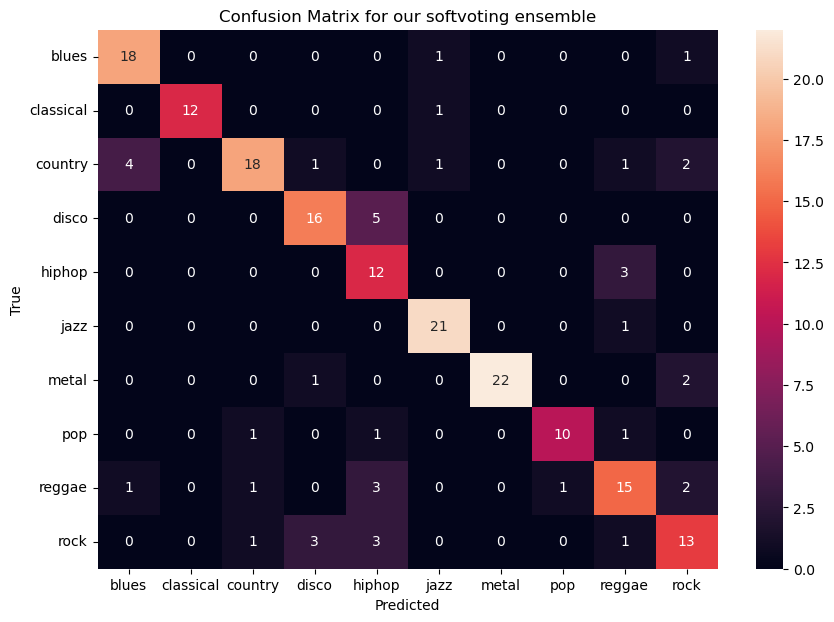

In [53]:
##creating a confusion matrix
cm = confusion_matrix(y_true, y_pred_final)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for our softvoting ensemble")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()